In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from fairlearn.metrics import MetricFrame, mean_prediction, selection_rate
from fairlearn.datasets import fetch_acs_income

warnings.filterwarnings("ignore", category=FutureWarning)

# Load the ACSIncome dataset directly from Fairlearn
data = fetch_acs_income(as_frame=True)

# Extract features and target as DataFrames
X = data.data  # Features
y = data.target  # Target

# Combine into a single DataFrame for easier inspection
df = pd.concat([X, y.rename('income')], axis=1)

df.drop("RELP", axis=1, inplace=True)

# Display the first few rows
print(df.head())

   AGEP  COW  SCHL  MAR    OCCP  POBP  WKHP  SEX  RAC1P   income
0  18.0  1.0  18.0  5.0  4720.0  13.0  21.0  2.0    2.0   1600.0
1  53.0  5.0  17.0  5.0  3605.0  18.0  40.0  1.0    1.0  10000.0
2  41.0  1.0  16.0  5.0  7330.0   1.0  40.0  1.0    1.0  24000.0
3  18.0  6.0  18.0  5.0  2722.0   1.0   2.0  2.0    1.0    180.0
4  21.0  5.0  19.0  5.0  3870.0  12.0  50.0  1.0    1.0  29000.0


In [2]:
#convert from float to integer

df['COW'] = df['COW'].round().astype(int)
df['SCHL'] = df['SCHL'].round().astype(int)
df['MAR'] = df['MAR'].round().astype(int)
df['SEX'] = df['SEX'].round().astype(int)
df['RAC1P'] = df['RAC1P'].round().astype(int)
df['OCCP'] = df['OCCP'].round().astype(int)
df['POBP'] = df['POBP'].round().astype(int)

#define a function that turns integers into strings for easier interpretation
def encode_dataset(df):
    cow_mapping = {
        1: "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
        2: "Employee of a private not-for-profit, tax-exempt, or charitable organization",
        3: "Local government employee (city, county, etc.)",
        4: "State government employee",
        5: "Federal government employee",
        6: "Self-employed in own not incorporated business, professional practice, or farm",
        7: "Self-employed in own incorporated business, professional practice or farm",
        8: "Working without pay in family business or farm",
        9: "Unemployed and last worked 5 years ago or earlier or never worked",
    }
    df['COW'] = df['COW'].map(cow_mapping)
    
    schl_mapping = {
        1: "No schooling completed",
        2: "Nursery school or preschool",
        3: "Kindergarten",
        4: "Grade 1",
        5: "Grade 2",
        6: "Grade 3",
        7: "Grade 4",
        8: "Grade 5",
        9: "Grade 6",
        10: "Grade 7",
        11: "Grade 8",
        12: "Grade 9",
        13: "Grade 10",
        14: "Grade 11",
        15: "Grade 12 (no diploma)",
        16: "Regular high school diploma",
        17: "GED or alternative credential",
        18: "Some college but less than 1 year",
        19: "1 or more years of college credit but no degree",
        20: "Associate’s degree",
        21: "Bachelor’s degree",
        22: "Master’s degree",
        23: "Professional degree beyond a bachelor’s degree",
        24: "Doctorate degree",
    }
    df.loc[:, 'SCHL'] = df['SCHL'].map(schl_mapping)
    
    mar_mapping = {
        1: "Married",
        2: "Widowed",
        3: "Divorced",
        4: "Separated",
        5: "Never married or under 15 years old",
    }
    df.loc[:, 'MAR'] = df['MAR'].map(mar_mapping)
   
    sex_mapping = {1: "Male", 2: "Female"}
    df.loc[:, 'SEX'] = df['SEX'].map(sex_mapping)
    
    race_mapping = {
        1: "White alone",
        2: "Black or African American alone",
        3: "American Indian alone",
        4: "Alaska Native alone",
        5: "American Indian and Alaska native tribes specified; or American Indian or Alaska Native, not specified and no other races",
        6: "Asian alone",
        7: "Native Hawaiian and Other Pacific Islander alone",
        8: "Some Other Race alone",
        9: "Two or More races",
    }
    df.loc[:, 'RAC1P'] = df['RAC1P'].map(race_mapping)
 
    return df

# Apply encoding
df = encode_dataset(df)

continuous = df[["AGEP", "WKHP", "income"]]

categorical = df[["RAC1P", "SEX", "MAR", "SCHL", "COW"]]

#one hot encoding for categorical variables
encoded_df = pd.get_dummies(categorical, drop_first = True)

X = pd.concat([encoded_df, continuous], axis=1)
y = X["income"]

X = X.drop(columns=['income'])

In [3]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

sensitive_feature_train = X_train['SEX_Male']
sensitive_feature_train.name = 'sex'
sensitive_feature_train = sensitive_feature_train.map({True: "Male", False: "Female"})

sensitive_feature_test = X_test['SEX_Male']
sensitive_feature_test.name = 'sex'
sensitive_feature_test = sensitive_feature_test.map({True: "Male", False: "Female"})

X_train_mod = X_train.drop(columns=['SEX_Male'])

X_test_mod = X_test.drop(columns=['SEX_Male'])

In [4]:
# Model training, note that overfitting restrictions are really important here
model = RandomForestRegressor(random_state=42, max_depth=8, min_samples_leaf=100, bootstrap=True)
model.fit(X_train_mod, y_train)

RandomForestRegressor(max_depth=8, min_samples_leaf=100, random_state=42)

In [5]:
# Predictions
y_pred = model.predict(X_test_mod)

In [6]:
#this examines the calibration of the model
from sklearn.linear_model import LinearRegression

# Fit regression model
reg = LinearRegression()
reg.fit(np.array(y_pred).reshape(-1, 1), y_test)

# Get slope and intercept
slope = reg.coef_[0]
intercept = reg.intercept_

print(f"Calibration Slope: {slope:.2f}, Calibration Intercept: {intercept:.2f}")

Calibration Slope: 1.01, Calibration Intercept: -836.91


In [7]:
# Convert to a DataFrame for easier handling
data_calibration = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred,
    'sensitive_feature': sensitive_feature_test
})

# Function to compute calibration slope and intercept for each group
def compute_calibration_by_group(data_calibration, group_col, y_true_col, y_pred_col):
    results = []
    
    for group, group_data in data_calibration.groupby(group_col):
        y_true_group = group_data[y_true_col]
        y_pred_group = group_data[y_pred_col]
        
        # Fit a linear regression model
        reg = LinearRegression()
        reg.fit(y_pred_group.values.reshape(-1, 1), y_true_group)
        
        # Get slope and intercept
        slope = reg.coef_[0]
        intercept = reg.intercept_
        
        results.append({
            'Group': group,
            'Calibration Slope': slope,
            'Calibration Intercept': intercept
        })
    
    return pd.DataFrame(results)

# Compute calibration slope and intercept by sensitive feature
calibration_results = compute_calibration_by_group(
    data_calibration, 
    group_col='sensitive_feature', 
    y_true_col='y_test', 
    y_pred_col='y_pred'
)

# Display the results
print("Calibration Results by Sensitive Feature")
print(calibration_results.to_string(index=False))

Calibration Results by Sensitive Feature
 Group  Calibration Slope  Calibration Intercept
Female           0.804414            2972.353140
  Male           1.117210            -619.737453


Overall metrics:
Mean Absolute Error    30511.76
Mean Prediction        56631.08
dtype: float64

Group metrics:
        Mean Absolute Error  Mean Prediction
sex                                         
Female             25190.97         51649.86
Male               35406.84         61213.77


array([[<Axes: title={'center': 'Mean Absolute Error'}, xlabel='sex'>,
        <Axes: title={'center': 'Mean Prediction'}, xlabel='sex'>,
        <Axes: xlabel='sex'>]], dtype=object)

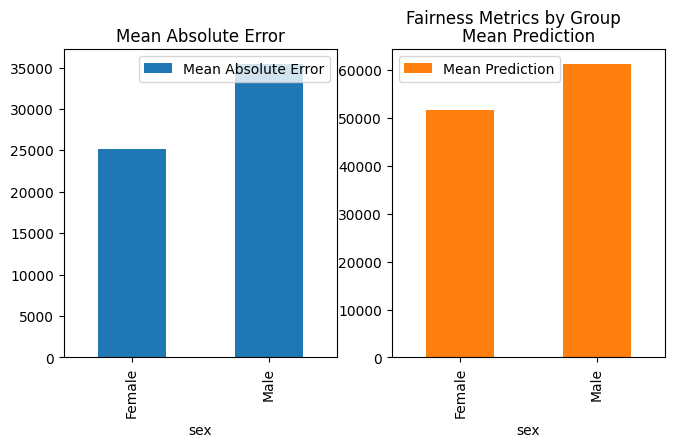

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import mean_prediction, selection_rate

def mean_prediction(y_true, y_pred):
    return np.mean(y_pred)

# Fairness evaluation for Gender

my_metrics = {
    'Mean Absolute Error': mean_absolute_error,
    'Mean Prediction': mean_prediction
}

# Use MetricFrame to compute metrics for each group
metrics = MetricFrame(
    metrics=my_metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_feature_test
)

# Print results
print("Overall metrics:")
print(metrics.overall.round(2))

print("\nGroup metrics:")
print(metrics.by_group.round(2))

# Visualize results
metrics.by_group.plot.bar(
    subplots=True,
    layout=(1, 3),
    figsize=(12, 4),
    title="Fairness Metrics by Group"
)

In [9]:
#Convert into binary decision

threshold = 70000

y_pred_binary = np.where(y_pred > threshold, 1, 0)
y_test_binary = np.where(y_test > threshold, 1, 0)

In [10]:
#Examine fairness of decision

from fairlearn.metrics import MetricFrame, false_positive_rate, false_negative_rate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define performance and fairness metrics
metrics = {
    'Accuracy': accuracy_score,
    'Precision': precision_score,
    'Recall': recall_score,
    'F1 Score': f1_score,
    'FPR': false_positive_rate,
    'FNR': false_negative_rate
}

# Create MetricFrame
metric_frame = MetricFrame(
    metrics=metrics,
    y_true=y_test_binary,
    y_pred=y_pred_binary,
    sensitive_features=sensitive_feature_test
)

# Print metrics by group
print("Metrics by group:")
print(metric_frame.by_group)

# Print overall metrics
print("\nOverall metrics:")
print(metric_frame.overall)

Metrics by group:
        Accuracy  Precision    Recall  F1 Score       FPR       FNR
sex                                                                
Female  0.809643   0.445122  0.640355  0.525181  0.157051  0.359645
Male    0.767002   0.594752  0.670136  0.630198  0.192221  0.329864

Overall metrics:
Accuracy     0.787434
Precision    0.535707
Recall       0.660071
F1 Score     0.591422
FPR          0.173860
FNR          0.339929
dtype: float64


In [11]:
# Define positive prediction rate as a custom metric
def positive_prediction_rate(y_true, y_pred):
    return sum(y_pred) / len(y_pred)

# Create MetricFrame for demographic parity
metric_frame = MetricFrame(
    metrics=positive_prediction_rate,
    y_true=y_test_binary,
    y_pred=y_pred_binary,
    sensitive_features=sensitive_feature_test
)

# Calculate demographic parity ratio
rates = metric_frame.by_group
dp_ratio = rates.min() / rates.max()  # Ratio of min to max rate
print("Positive Prediction Rates by Group:")
print(rates)
print(f"Demographic Parity Ratio: {dp_ratio:.2f}")

Positive Prediction Rates by Group:
sex
Female    0.236506
Male      0.333806
Name: positive_prediction_rate, dtype: float64
Demographic Parity Ratio: 0.71


In [12]:
from fairlearn.metrics import MetricFrame, true_positive_rate, false_positive_rate

# Create MetricFrame for TPR and FPR
metric_frame = MetricFrame(
    metrics={
        'TPR': true_positive_rate,
        'FPR': false_positive_rate
    },
    y_true=y_test_binary,
    y_pred=y_pred_binary,
    sensitive_features=sensitive_feature_test
)

# Calculate ratios for TPR and FPR
tpr_rates = metric_frame.by_group['TPR']
fpr_rates = metric_frame.by_group['FPR']

tpr_ratio = tpr_rates.min() / tpr_rates.max()
fpr_ratio = fpr_rates.min() / fpr_rates.max()

print("True Positive Rates by Group:")
print(tpr_rates)
print(f"TPR Ratio: {tpr_ratio:.2f}")

print("\nFalse Positive Rates by Group:")
print(fpr_rates)
print(f"FPR Ratio: {fpr_ratio:.2f}")

True Positive Rates by Group:
sex
Female    0.640355
Male      0.670136
Name: TPR, dtype: float64
TPR Ratio: 0.96

False Positive Rates by Group:
sex
Female    0.157051
Male      0.192221
Name: FPR, dtype: float64
FPR Ratio: 0.82
